# War fatalities in Russia in 2022--2023 estimated via excess male mortality
## External deaths by cause

In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

plt.style.use("mpl_style.txt")

In [2]:
df_causes = pd.read_excel('../deaths-by-cause-region-year/fedstat31620.xls')

df_causes

,"Число умерших по основным классам и отдельным причинам смерти за год (человек, значение показателя за год)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1990,NaN,NaN,1991,NaN,NaN,1992,NaN,...,NaN,2021,NaN,NaN,2022,NaN,NaN,2023,NaN,NaN
2,NaN,NaN,все население,городское население,сельское население,все население,городское население,сельское население,все население,городское население,...,сельское население,все население,городское население,сельское население,все население,городское население,сельское население,все население,городское население,сельское население
3,Болезни органов дыхания,Российская Федерация,87970,50247,37723,82817,47906,34911,86041,50424,...,29847,114727,78278,36449,81504,55073,26431,77575,52391,25184
4,Болезни органов дыхания,Центральный федеральный округ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5267,25288,18647,6641,19511,13985,5526,19345,14155,5190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,Цереброваскулярные болезни,Магаданская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16,263,248,15,213,203,10,199,190,9
1926,Цереброваскулярные болезни,Сахалинская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138,587,472,115,593,471,122,594,468,126
1927,Цереброваскулярные болезни,Еврейская автономная область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130,304,215,89,295,188,107,248,173,75
1928,Цереброваскулярные болезни,Чукотский автономный округ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11,31,20,11,28,16,12,28,14,14


In [3]:
external = df_causes.values[363][26::3].astype(float)  / 1000
traffic  = df_causes.values[580][26::3].astype(float)  / 1000
suicides = df_causes.values[1357][26::3].astype(float) / 1000
alcohol  = df_causes.values[1477][26::3].astype(float) / 1000
murders  = df_causes.values[1702][26::3].astype(float) / 1000

print(df_causes.values[[363, 580, 1357, 1477, 1702], :2])

rest = external - suicides - alcohol - traffic - murders
 
years = np.arange(2000, 2024)

[['внешние причины' 'Российская Федерация']
 ['все виды транспортных несчастных случаев' 'Российская Федерация']
 ['Самоубийство' 'Российская Федерация']
 ['Случ.отравл.алкоголем' 'Российская Федерация']
 ['Убийство' 'Российская Федерация']]


Excess in rest:
2022: 29885 +- 2797
2023: 47576 +- 3186

Excess in all:
2022: 41439 +- 4880
2023: 62419 +- 5559


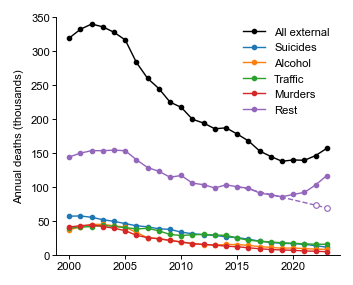

In [4]:
fig = plt.figure(figsize=(2.5, 2))

plt.plot(years, external, 'k.-', label='All external')
plt.plot(years, suicides, '.-', label='Suicides')
plt.plot(years, alcohol, '.-', label='Alcohol')
plt.plot(years, traffic, '.-', label='Traffic')
plt.plot(years, murders, '.-', label='Murders')
restline = plt.plot(years, rest, '.-', label='Rest')

LinReg = LinearRegression()
LinReg.fit(years[-9:-4].reshape(-1,1), rest[-9:-4].reshape(-1,1))
yhat_sklearn = LinReg.predict(years[-9:].reshape(-1,1)).flatten()

plt.plot(years[-9:], yhat_sklearn, '--', zorder=0, color=restline[0].get_color())
plt.plot(years[-2], yhat_sklearn[-2], 'o', color='w', markeredgecolor=restline[0].get_color(),
            markersize=3, markeredgewidth=.6)
plt.plot(years[-1], yhat_sklearn[-1], 'o', color='w', markeredgecolor=restline[0].get_color(),
            markersize=3, markeredgewidth=.6)

# Compute the uncertainty
beg = 9
X = np.concatenate((years[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
y = rest[-beg:].reshape(-1,1)
beta = np.linalg.pinv(X[-beg:-4].T @ X[-beg:-4]) @ X[-beg:-4].T @ y[-beg:-4]
yhat = X[-beg:] @ beta
sigma2 = np.sum((y[-beg:-4] - yhat[-beg:-4])**2) / (y[-beg:-4].size - 2) # sigma^2 = MSE/(n-p)
S = np.linalg.pinv(X[-beg:-4].T @ X[-beg:-4])
predictive_var = sigma2 * X[-2:] @ S @ X[-2:].T + sigma2
predictive_std = np.sqrt(np.diag(predictive_var)) 

assert(np.allclose(yhat.ravel(), yhat_sklearn))

print(f'Excess in rest:')
print(f'2022: {(rest[-2] - yhat_sklearn[-2]) * 1000:.0f} +- {predictive_std[0] * 1000:.0f}')
print(f'2023: {(rest[-1] - yhat_sklearn[-1]) * 1000:.0f} +- {predictive_std[1] * 1000:.0f}')

LinReg.fit(years[-9:-4].reshape(-1,1), external[-9:-4].reshape(-1,1))
yhat_sklearn = LinReg.predict(years[-9:].reshape(-1,1)).flatten()

# Compute the uncertainty
beg = 9
X = np.concatenate((years[-beg:].reshape(-1,1), np.ones((beg,1))), axis=1)
y = external[-beg:].reshape(-1,1)
beta = np.linalg.pinv(X[-beg:-4].T @ X[-beg:-4]) @ X[-beg:-4].T @ y[-beg:-4]
yhat = X[-beg:] @ beta
sigma2 = np.sum((y[-beg:-4] - yhat[-beg:-4])**2) / (y[-beg:-4].size - 2) # sigma^2 = MSE/(n-p)
S = np.linalg.pinv(X[-beg:-4].T @ X[-beg:-4])
predictive_var = sigma2 * X[-2:] @ S @ X[-2:].T + sigma2
predictive_std = np.sqrt(np.diag(predictive_var)) 

assert(np.allclose(yhat.ravel(), yhat_sklearn))

print('')
print(f'Excess in all:')
print(f'2022: {(external[-2] - yhat_sklearn[-2]) * 1000:.0f} +- {predictive_std[0] * 1000:.0f}')
print(f'2023: {(external[-1] - yhat_sklearn[-1]) * 1000:.0f} +- {predictive_std[1] * 1000:.0f}')

plt.ylabel('Annual deaths (thousands)')
plt.legend()
plt.ylim([0, 350])

plt.savefig('figures/external.pdf')
plt.savefig('figures/external.png')